I have wanted to try implementing an iterated local search metaheuristic on top of the [`alns`](https://github.com/N-Wouda/ALNS/) and [`pyvrp`](https://github.com/PyVRP/PyVRP/) packages for some time.
In this post I am going to do so, by building a very simple metaheuristic that already works very well for the vehicle routing problem with time windows.<!-- TEASER_END -->

Let's first import what we will use in this post.

In [153]:
from alns import ALNS, Result
from alns.accept import HillClimbing
from alns.select import RandomSelect
from alns.stop import MaxRuntime, StoppingCriterion

import matplotlib.pyplot as plt
import numpy as np

from pyvrp import (
    CostEvaluator,
    Solution,
    PenaltyManager,
    ProblemData,
    RandomNumberGenerator,
    read,
)
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.plotting import plot_solution
from pyvrp.search import LocalSearch, NODE_OPERATORS, compute_neighbours

In [154]:
%config InlineBackend.figure_formats = ['svg']

# The idea

[Iterated local search](https://en.wikipedia.org/wiki/Iterated_local_search) (ILS) is a metaheuristic built on top of a local search algorithm.
In each iteration, the current solution is modified (perturbed), and then passed into the local search algorithm for improvement.
This perturbate-and-improve continues until some stopping criterion is met.

Within the `alns` package we already provide many of the building blocks needed to implement ILS.
In particular, we offer a framework that iteratively calls a _destroy_ and _repair_ operator pair (read: perturb and improve), until some stopping criterion is met.
Thus, [ILS can be implemented efficiently on top of ALNS](https://alns.readthedocs.io/en/latest/examples/other%20single-trajectory%20heuristics.html#ils), provided a perturbation scheme and local search procedure are available.
The perturbation scheme and local search procedure both come from `pyvrp`, as we will see.
Thus, there is very little work remaining in developing an ILS for VRP-type problems!

# The implementation

We will need to develop three things: a solution state, a perturbation scheme, and a local search procedure.
Luckily, we can wrap relevant components from `alns` and `pyvrp` to do most of the heavy lifting for us.

Let's start with the solution state.
Here we will wrap the `Solution` class from `pyvrp` to make it work correctly with `alns`.

In [155]:
class VrpState:
    def __init__(self, sol: Solution, cost_eval: CostEvaluator):
        self.sol = sol
        self.cost_eval = cost_eval

    def objective(self) -> float:
        return self.cost_eval.penalised_cost(self.sol)

Here we have implemented a vehicle routing problem state that tracks a solution `sol`, and a cost evaluator `cost_eval`  that can be used to determine the solution's cost value.
The cost evaluator is important because PyVRP uses penalty terms to guide the search towards feasible solutions, and thus the objective value of a solution is not fixed w.r.t. these changing penalties.

We will now implement the perturbation scheme and local search procedure as `alns` operators.
Since both operators rely on shared state, we will implement them on a shared class `Operators`.

In [156]:
class Operators:
    def __init__(
        self,
        data: ProblemData,
        rng: RandomNumberGenerator,
        pm: PenaltyManager,
    ):
        self.data = data
        self.rng = rng
        self.pm = pm
        self.ls = LocalSearch(data, rng, compute_neighbours(data))

        for op in NODE_OPERATORS:
            self.ls.add_node_operator(op(data))

    def perturb(self, state: VrpState, _, **kwargs) -> VrpState:
        """
        The perturbation scheme. Given a solution state, this operator uses
        the SREX crossover of PyVRP to create a new solution that combines
        the given state and some randomness.
        """
        rnd_sol = Solution.make_random(self.data, self.rng)
        curr_sol = state.sol

        # SREX of Nagata et al. (2010).
        cost_eval = self.pm.get_cost_evaluator()
        srex_sol = srex((rnd_sol, curr_sol), self.data, cost_eval, self.rng)
        return VrpState(srex_sol, cost_eval)

    def improve(self, state: VrpState, _, **kwargs) -> VrpState:
        """
        The improve method uses the local search to improve the given solution
        state.
        """
        cost_eval = self.pm.get_cost_evaluator()
        new_sol = self.ls(state.sol, cost_eval)

        # This is very important! Registering the characteristics of the new
        # solution allows the penalty manager to appropriately update the
        # penalty terms for infeasibility.
        self.pm.register_load_feasible(not new_sol.has_excess_load())
        self.pm.register_time_feasible(not new_sol.has_time_warp())

        return VrpState(new_sol, cost_eval)

Our perturbation scheme uses PyVRP's implementation of the selective route exchange (SREX) crossover operator of [Nagata et al. (2010)](https://doi.org/10.1007/978-3-642-15844-5_54).
This is one of the best crossover operators for VRP, and often used in genetic algorithms for those problems.
Here, however, we use it to combine a random solution with our current solution state: that provides a lot of diversity 'for free'.

We are now ready to write our `solve` routine:

In [157]:
def solve(
    data: ProblemData,
    rng: RandomNumberGenerator,
    pm: PenaltyManager,
    stop: StoppingCriterion,
) -> Result:
    rnd_state = np.random.RandomState(seed=rng.randint(100))
    alns = ALNS(rnd_state)

    ops = Operators(data, rng, pm)
    alns.add_destroy_operator(ops.perturb)  # type: ignore
    alns.add_repair_operator(ops.improve)  # type: ignore

    accept = HillClimbing()
    select = RandomSelect(1, 1)

    init = Solution.make_random(data, rng)
    init_sol = VrpState(init, pm.get_cost_evaluator())
    return alns.iterate(init_sol, select, accept, stop)

# A simple experiment

We will solve [the `C1_10_1` VRPTW instance](https://github.com/PyVRP/Instances/blob/main/VRPTW/C1_10_1.txt), which has a known optimal solution with cost `42444.8` (`424448` under the DIMACS convention).
This instance has 1000 client visits.

Let's give our solver 15 seconds of runtime:

In [158]:
data = read("data/C1_10_1.vrp", round_func="dimacs", instance_format="solomon")
rng = RandomNumberGenerator(seed=42)
pm = PenaltyManager()
stop = MaxRuntime(15)

res = solve(data, rng, pm, stop)

In [159]:
res.best_state.objective()

424448

That was sufficient to find the optimal solution!
Let's inspect our solution further, using the plotting tools in PyVRP:

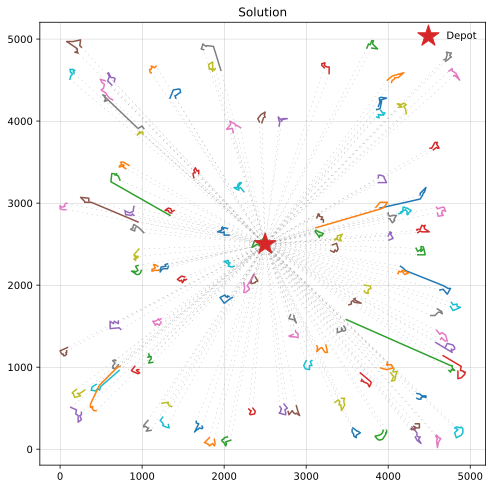

In [160]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best_state.sol, data, ax=ax)

# Conclusion

In this notebook we built an iterated local search metaheuristic on top of the `alns` and `pyvrp` packages.
This was really easy to do, because these packages already provide many of the components needed for iterated local search.
We kept things simple, but easily found an optimal solution to a large VRPTW instance.
The algorithm presented here might be improved further, particularly by improving the perturbation scheme.